In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

DIR = "/content/drive/MyDrive/ML_project/data/fungi_train_val"
directories = []

folders = os.listdir(DIR)

for folder in folders:
    photos = os.listdir(DIR + "/" + folder)
    cat = ' '.join(folder.split('_')[1:])
    super_cat = folder.split('_')[1]
    for photo in photos:
        path = DIR + "/" + folder + "/" + photo
        directories.append({
            'super_category': super_cat, 
            'category': cat, 
            'path': path
        })
        
df = pd.DataFrame(directories)
df.head()

,super_category,category,path
0,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
1,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
2,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
3,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...
4,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...


In [3]:
df_sorted = df.groupby(['category']).count().rename(columns={'path':'count'})[['count']].sort_values(by='count', ascending=False)
df_sorted

,count
category,
Plicatura crispa,442
Pluteus cervinus,419
Tricholoma scalpturatum,414
Xerocomellus chrysenteron,406
Mycena galericulata,375
Byssomerulius corium,374
Cylindrobasidium laeve,364
Armillaria lutea,352
Ganoderma pfeifferi,342


In [64]:
# Global parameters
n_classes = 20
samples_per_class = 255
training_size_ratio = 0.8
IMG_SIZE = (224, 224)
validation_size_ratio = 0.2
batch_size = 32             # if None is 32 (default)
learning_rate = 0.001
patience = 10

In [5]:
# Check if a run with these parameters already exists

df_results = pd.read_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv")
df_results = df_results.loc[(df_results["classes"] == n_classes) &
               (df_results["samples"] == samples_per_class) &
               (df_results["image_height"] == img_size) &
               (df_results["image_width"] == img_size) &
               (df_results["training"] == training_size_ratio) &
               (df_results["dense_layer_1"] == dense_layer_1) &
               (df_results["dense_layer_2"] == dense_layer_2) &
               (df_results["batch_size"] == batch_size) &
               (df_results["learning_rate"] == learning_rate) &
               (df_results["patience"] == patience)]
if df_results.shape[0]:
  print("A run with these parameters already exist, results are:")
  print("Epochs:", df_results.iloc[0]['epochs'])
  print("Training time: %ih %im %is" % 
        (df_results.iloc[0]['training_time_hours'], df_results.iloc[0]['training_time_minutes'], df_results.iloc[0]['training_time_seconds']))
  print("Accuracy:", "{:.2f}".format(df_results.iloc[0]['accuracy']*100) + "%")
  print("Loss:", "{:.4f}".format(df_results.iloc[0]['loss']))
else:
  print("A run with these parameters doesn't exists.")

NameError: ignored

In [65]:
reference = 'category'
#n_classes = df_sorted.shape[0]

classes = df[reference].drop_duplicates()
df1 = pd.DataFrame()
for i, v in df_sorted.iloc[:n_classes].iterrows():
    size = min(samples_per_class, df.loc[df[reference] == i].shape[0])
    training_size = int(size*training_size_ratio)
    validation_size = int(training_size*validation_size_ratio)

    tmp_df = df.loc[df[reference] == i].iloc[:training_size-validation_size]
    tmp_df['split'] = 'train'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size-validation_size:training_size]
    tmp_df['split'] = 'val'
    df1 = df1.append(tmp_df)

    tmp_df = df.loc[df[reference] == i].iloc[training_size:samples_per_class]
    tmp_df['split'] = 'test'
    df1 = df1.append(tmp_df)
    
df1.head()

,super_category,category,path,split
0,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,train
1,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,train
2,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,train
3,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,train
4,Plicatura,Plicatura crispa,/content/drive/MyDrive/ML_project/data/fungi_t...,train


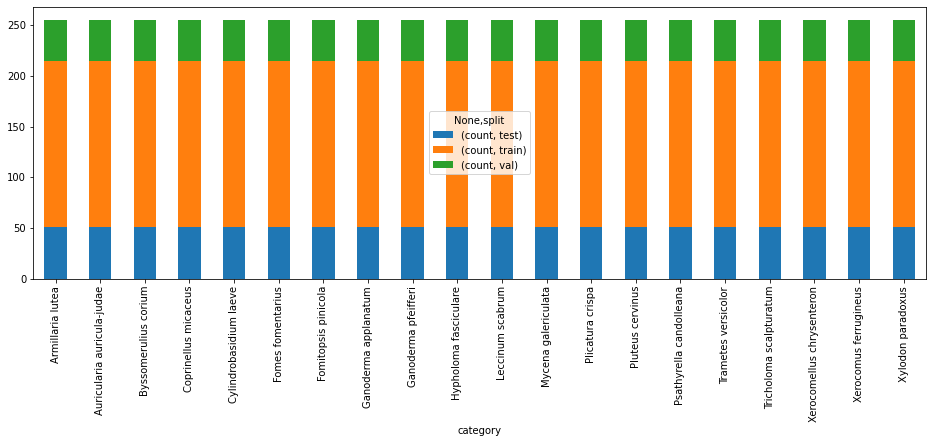

In [66]:
import pandas as pd

df_count = df1.groupby(['category','split']).count().rename(columns={'path':'count'})[['count']]
df_count = df_count.unstack('split')
df_count.plot(kind='bar', stacked=True, figsize=(16,5))

In [67]:
df_training = df1.loc[df1['split'] == 'train']
df_validation = df1.loc[df1['split'] == 'val']
df_test = df1.loc[df1['split'] == 'test']

print("Training set:", df_training.shape[0])
print("Validation set:", df_validation.shape[0])
print("Test set:", df_test.shape[0])

Training set: 3280
Validation set: 800
Test set: 1020


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DIR = os.getcwd()

training_datagen = ImageDataGenerator()

"""
training_datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
) """

train_generator = training_datagen.flow_from_dataframe(
    df_training,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 3280 validated image filenames belonging to 20 classes.


In [69]:
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    df_validation,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical'
)

Found 800 validated image filenames belonging to 20 classes.


In [70]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    DIR,
    'path',
    'category',
    target_size=(IMG_SIZE),
    class_mode='categorical',
    shuffle=False
)

Found 1020 validated image filenames belonging to 20 classes.


In [71]:
classes = []

for i in train_generator.class_indices:
    classes.append(i)

print(classes)

['Armillaria lutea', 'Auricularia auricula-judae', 'Byssomerulius corium', 'Coprinellus micaceus', 'Cylindrobasidium laeve', 'Fomes fomentarius', 'Fomitopsis pinicola', 'Ganoderma applanatum', 'Ganoderma pfeifferi', 'Hypholoma fasciculare', 'Leccinum scabrum', 'Mycena galericulata', 'Plicatura crispa', 'Pluteus cervinus', 'Psathyrella candolleana', 'Trametes versicolor', 'Tricholoma scalpturatum', 'Xerocomellus chrysenteron', 'Xerocomus ferrugineus', 'Xylodon paradoxus']


In [72]:
# From https://www.tensorflow.org/tutorials/images/transfer_learning
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [81]:
from tensorflow.keras import applications
from tensorflow.keras.layers import Input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [82]:
base_model.trainable = False

In [83]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(units=n_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [84]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_8 True
sequential_3 True
tf.math.truediv_3 True
tf.math.subtract_3 True
mobilenetv2_1.00_224 False
global_average_pooling2d_3 True
dropout_3 True
dense_3 True


In [85]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [86]:
base_learning_rate = 0.0001
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy','top_k_categorical_accuracy'])

In [87]:
def elapsed_time(start_time):
    delta = time.time()-start_time
    hours = int(delta/(60*60))
    delta -= hours*(60*60)
    minut = int(delta/60)
    delta -= minut*60
    sec = int(delta)
    return (hours, minut, sec)

In [88]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import time

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

checkpoint_filepath = '/tmp/checkpoint'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

start_time = time.time()

history = model.fit(train_generator, epochs=100, batch_size=batch_size,
            validation_data = validation_generator,
            verbose=1, callbacks=[early_stopping,checkpoint_callback])

training_time = elapsed_time(start_time)
print("Elapsed time: %ih %im %is" % training_time)

# model.load_weights(checkpoint_filepath)
#model.save('/content/drive/MyDrive/ML_project/model.h5')

Epoch 1/100
103/103 [==============================] - 46s 426ms/step - loss: 3.4043 - accuracy: 0.0620 - top_k_categorical_accuracy: 0.2821 - val_loss: 2.9058 - val_accuracy: 0.1037 - val_top_k_categorical_accuracy: 0.4150
Epoch 2/100
103/103 [==============================] - 43s 417ms/step - loss: 2.8689 - accuracy: 0.1317 - top_k_categorical_accuracy: 0.4794 - val_loss: 2.5961 - val_accuracy: 0.1813 - val_top_k_categorical_accuracy: 0.5925
Epoch 3/100
103/103 [==============================] - 43s 415ms/step - loss: 2.5282 - accuracy: 0.2011 - top_k_categorical_accuracy: 0.6191 - val_loss: 2.3659 - val_accuracy: 0.2500 - val_top_k_categorical_accuracy: 0.7088
Epoch 4/100
103/103 [==============================] - 43s 418ms/step - loss: 2.2920 - accuracy: 0.2654 - top_k_categorical_accuracy: 0.7255 - val_loss: 2.1876 - val_accuracy: 0.3175 - val_top_k_categorical_accuracy: 0.7675
Epoch 5/100
103/103 [==============================] - 43s 417ms/step - loss: 2.1566 - accuracy: 0.3282 

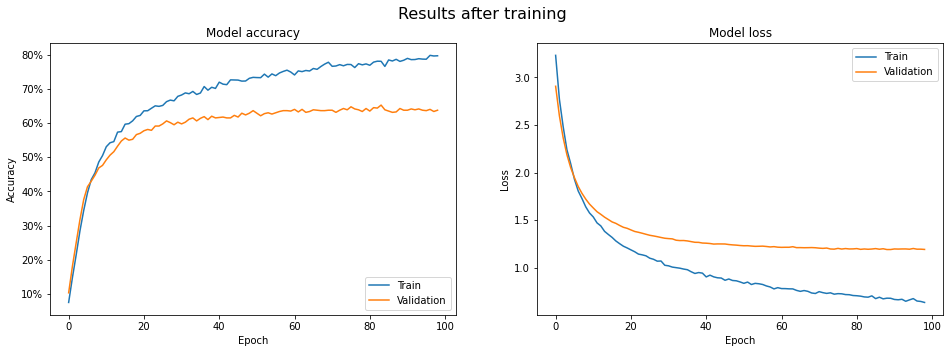

In [89]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [92]:
test_loss, test_acc, _ = model.evaluate(test_generator)

32/32 [==============================] - 11s 340ms/step - loss: 1.2393 - accuracy: 0.6088 - top_k_categorical_accuracy: 0.9392


In [93]:
import numpy as np
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator, df_test.shape[0] // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=classes))

Classification Report
                            precision    recall  f1-score   support

          Armillaria lutea       0.67      0.67      0.67        51
Auricularia auricula-judae       0.79      0.73      0.76        51
      Byssomerulius corium       0.61      0.71      0.65        51
      Coprinellus micaceus       0.66      0.69      0.67        51
    Cylindrobasidium laeve       0.71      0.67      0.69        51
         Fomes fomentarius       0.48      0.49      0.49        51
       Fomitopsis pinicola       0.48      0.53      0.50        51
      Ganoderma applanatum       0.42      0.49      0.45        51
       Ganoderma pfeifferi       0.56      0.55      0.55        51
     Hypholoma fasciculare       0.66      0.57      0.61        51
          Leccinum scabrum       0.63      0.73      0.67        51
       Mycena galericulata       0.55      0.53      0.54        51
          Plicatura crispa       0.74      0.67      0.70        51
          Pluteus cervinu

[Text(0.5, 0, 'Armillaria lutea'),
 Text(1.5, 0, 'Auricularia auricula-judae'),
 Text(2.5, 0, 'Byssomerulius corium'),
 Text(3.5, 0, 'Coprinellus micaceus'),
 Text(4.5, 0, 'Cylindrobasidium laeve'),
 Text(5.5, 0, 'Fomes fomentarius'),
 Text(6.5, 0, 'Fomitopsis pinicola'),
 Text(7.5, 0, 'Ganoderma applanatum'),
 Text(8.5, 0, 'Ganoderma pfeifferi'),
 Text(9.5, 0, 'Hypholoma fasciculare'),
 Text(10.5, 0, 'Leccinum scabrum'),
 Text(11.5, 0, 'Mycena galericulata'),
 Text(12.5, 0, 'Plicatura crispa'),
 Text(13.5, 0, 'Pluteus cervinus'),
 Text(14.5, 0, 'Psathyrella candolleana'),
 Text(15.5, 0, 'Trametes versicolor'),
 Text(16.5, 0, 'Tricholoma scalpturatum'),
 Text(17.5, 0, 'Xerocomellus chrysenteron'),
 Text(18.5, 0, 'Xerocomus ferrugineus'),
 Text(19.5, 0, 'Xylodon paradoxus')]

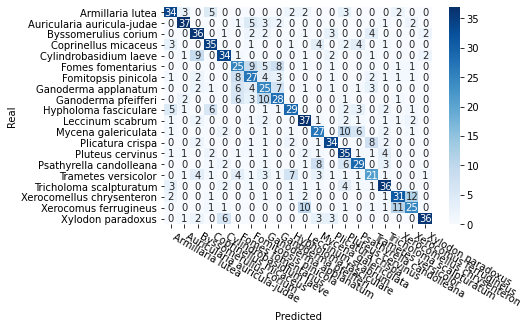

In [94]:
df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt = sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.set_ylabel("Real") 
plt.set_xlabel("Predicted")
plt.set_xticklabels(plt.get_xticklabels(), rotation=-30, ha="left") 

In [95]:
# Fine tuning

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [96]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy', 'top_k_categorical_accuracy'])

In [97]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0   

In [98]:
history_fine = model.fit(train_generator, 
                    epochs=len(history.history['accuracy']) + 20,
                    initial_epoch=history.epoch[-1],
                    batch_size=batch_size,
                    validation_data = validation_generator,
                    verbose=1, 
                    callbacks=[early_stopping,checkpoint_callback])

Epoch 99/119
103/103 [==============================] - 49s 435ms/step - loss: 1.3796 - accuracy: 0.5567 - top_k_categorical_accuracy: 0.9017 - val_loss: 1.1776 - val_accuracy: 0.6400 - val_top_k_categorical_accuracy: 0.9275
Epoch 100/119
103/103 [==============================] - 44s 426ms/step - loss: 1.0450 - accuracy: 0.6616 - top_k_categorical_accuracy: 0.9534 - val_loss: 1.1822 - val_accuracy: 0.6425 - val_top_k_categorical_accuracy: 0.9250
Epoch 101/119
103/103 [==============================] - 44s 423ms/step - loss: 0.9813 - accuracy: 0.6733 - top_k_categorical_accuracy: 0.9600 - val_loss: 1.1820 - val_accuracy: 0.6450 - val_top_k_categorical_accuracy: 0.9287
Epoch 102/119
103/103 [==============================] - 44s 426ms/step - loss: 0.8675 - accuracy: 0.7328 - top_k_categorical_accuracy: 0.9657 - val_loss: 1.1762 - val_accuracy: 0.6450 - val_top_k_categorical_accuracy: 0.9262
Epoch 103/119
103/103 [==============================] - 43s 420ms/step - loss: 0.8090 - accuracy

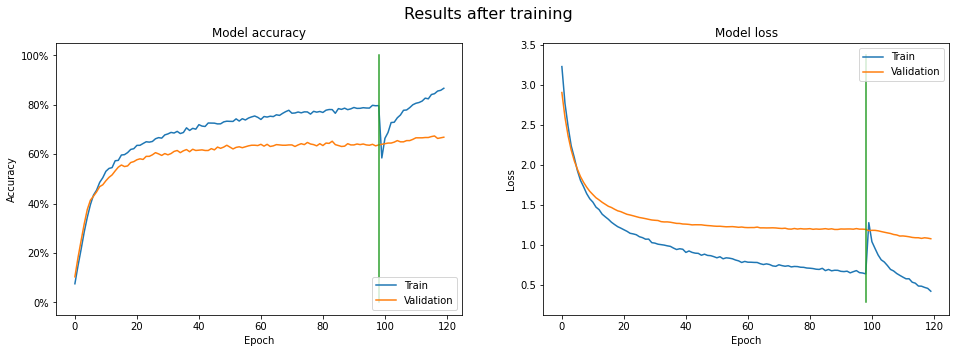

In [99]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(16,5))
fig.suptitle('Results after training', fontsize=16)

# summarize history for accuracy
axes[0].plot(history.history['accuracy']+history_fine.history['accuracy'])
axes[0].plot(history.history['val_accuracy']+history_fine.history['val_accuracy'])
axes[0].plot([len(history.history['accuracy'])-1,len(history.history['accuracy'])-1],
          plt.ylim(), label='Start Fine Tuning')
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='lower right')

# summarize history for loss
axes[1].plot(history.history['loss']+history_fine.history['loss'])
axes[1].plot(history.history['val_loss']+history_fine.history['val_loss'])
axes[1].plot([len(history.history['accuracy'])-1,len(history.history['accuracy'])-1],
          plt.ylim(), label='Start Fine Tuning')
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [100]:
test_loss, test_acc, _ = model.evaluate(test_generator)

32/32 [==============================] - 11s 341ms/step - loss: 1.1188 - accuracy: 0.6480 - top_k_categorical_accuracy: 0.9480


In [101]:
import numpy as np
import tensorflow as tf
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Confution Matrix and Classification Report
Y_pred = model.predict(test_generator, df_test.shape[0] // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=classes))

Classification Report
                            precision    recall  f1-score   support

          Armillaria lutea       0.64      0.71      0.67        51
Auricularia auricula-judae       0.85      0.80      0.83        51
      Byssomerulius corium       0.74      0.76      0.75        51
      Coprinellus micaceus       0.75      0.65      0.69        51
    Cylindrobasidium laeve       0.66      0.73      0.69        51
         Fomes fomentarius       0.47      0.41      0.44        51
       Fomitopsis pinicola       0.46      0.55      0.50        51
      Ganoderma applanatum       0.41      0.51      0.45        51
       Ganoderma pfeifferi       0.58      0.49      0.53        51
     Hypholoma fasciculare       0.76      0.67      0.71        51
          Leccinum scabrum       0.69      0.67      0.68        51
       Mycena galericulata       0.50      0.69      0.58        51
          Plicatura crispa       0.71      0.78      0.75        51
          Pluteus cervinu

[Text(0.5, 0, 'Armillaria lutea'),
 Text(1.5, 0, 'Auricularia auricula-judae'),
 Text(2.5, 0, 'Byssomerulius corium'),
 Text(3.5, 0, 'Coprinellus micaceus'),
 Text(4.5, 0, 'Cylindrobasidium laeve'),
 Text(5.5, 0, 'Fomes fomentarius'),
 Text(6.5, 0, 'Fomitopsis pinicola'),
 Text(7.5, 0, 'Ganoderma applanatum'),
 Text(8.5, 0, 'Ganoderma pfeifferi'),
 Text(9.5, 0, 'Hypholoma fasciculare'),
 Text(10.5, 0, 'Leccinum scabrum'),
 Text(11.5, 0, 'Mycena galericulata'),
 Text(12.5, 0, 'Plicatura crispa'),
 Text(13.5, 0, 'Pluteus cervinus'),
 Text(14.5, 0, 'Psathyrella candolleana'),
 Text(15.5, 0, 'Trametes versicolor'),
 Text(16.5, 0, 'Tricholoma scalpturatum'),
 Text(17.5, 0, 'Xerocomellus chrysenteron'),
 Text(18.5, 0, 'Xerocomus ferrugineus'),
 Text(19.5, 0, 'Xylodon paradoxus')]

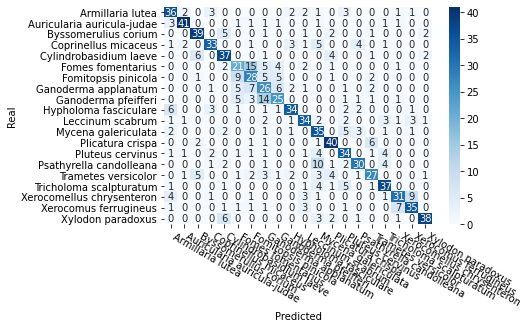

In [102]:
df_cm = pd.DataFrame(confusion_matrix(test_generator.classes, y_pred), 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt = sn.heatmap(df_cm, annot=True, cmap="Blues")
plt.set_ylabel("Real") 
plt.set_xlabel("Predicted")
plt.set_xticklabels(plt.get_xticklabels(), rotation=-30, ha="left") 

In [ ]:
print("Parameters:")
print("Classes:", n_classes)
print("Samples per class:", samples_per_class)
print("Image size:", img_size)
print("Training size:", training_size_ratio)
print("Dense layers:", dense_layer_1, "x", dense_layer_2)
print("Batch size:", batch_size)
print("Learning rate:", learning_rate)
print("Patience:", patience)

print("\nResults:")
print("Epochs:", len(history.history['accuracy']))
print("Training time: %ih %im %is" % training_time)
print("Accuracy:", "{:.2f}".format(test_acc*100) + "%")
print("Loss:", "{:.4f}".format(test_loss))

Parameters:
Classes: 20
Samples per class: 200
Image size: 224
Training size: 0.9
Dense layers: 4096 x 4096
Batch size: 32
Learning rate: 0.001
Patience: 10

Results:
Epochs: 22
Training time: 0h 38m 0s
Accuracy: 42.00%
Loss: 1.9979


In [ ]:
# Store parameters

df_results = pd.read_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv")
row = pd.DataFrame([[n_classes, samples_per_class, img_size, img_size, training_size_ratio,
                    dense_layer_1, dense_layer_2, batch_size, learning_rate,
                    patience, len(history.history['accuracy']), "{:.4f}".format(val_acc), "{:.4f}".format(val_loss),
                    training_time[0], training_time[1], training_time[2]]],
                   columns= ['classes', 'samples', 'image_height', 'image_width', 'training',
                             'dense_layer_1', 'dense_layer_2', 'batch_size',
                             'learning_rate', 'patience', 'epochs', 'accuracy', 'loss',
                             'training_time_hours', 'training_time_minutes', 'training_time_seconds'])
df_results = df_results.append(row)
df_results.to_csv("/content/drive/MyDrive/ML_project/runs_colab_gpu.csv", index=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


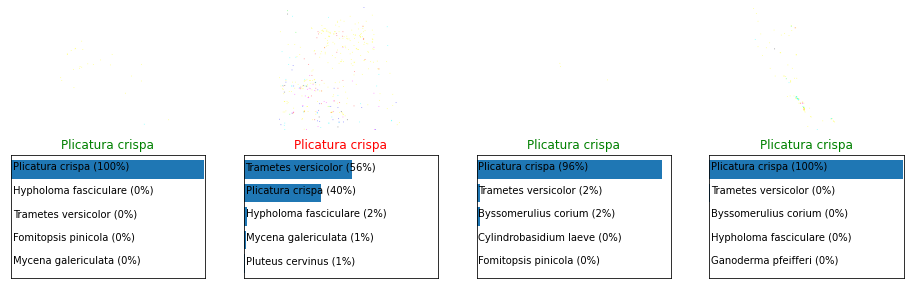

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


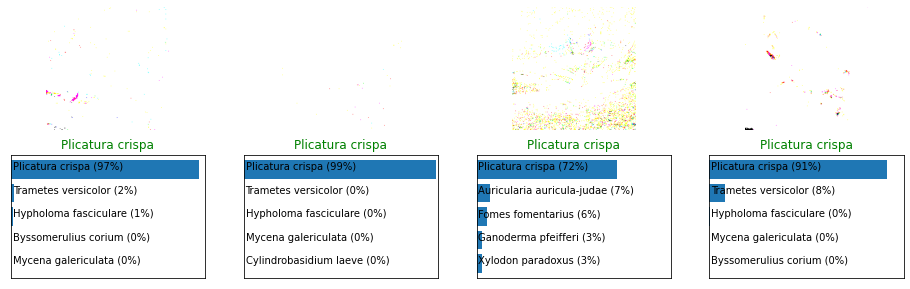

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


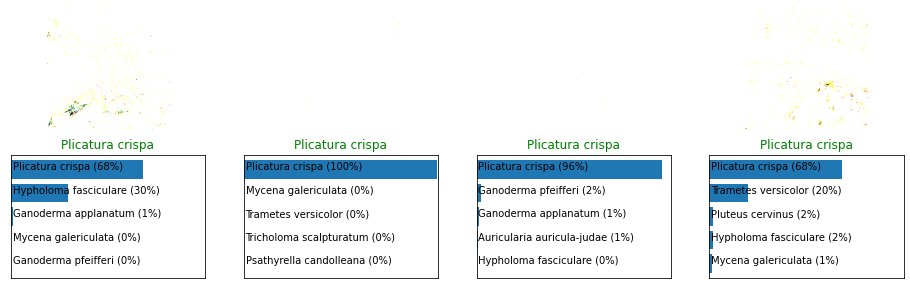

In [103]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import FuncFormatter
import numpy as np

iters = 0
n_predictions = 8
n_cols = 4
    
for i, batch in enumerate(test_generator):
    if iters > n_predictions:
        break
    
    batch_images, batch_labels = batch
    
    for j in range(len(batch_images)):
        if iters > n_predictions:
            break
            
        fig, axes = plt.subplots(2, n_cols, figsize=(16,5))
        
        for k in range(n_cols):
            prediction = model.predict(np.array([batch_images[j*n_cols+k]]))
            res = [{'label': classes[h], 'val': prediction[0][h]} for h in range(len(classes))]
            res.sort(key=lambda x: x['val'], reverse=True)
            res = res[0:5]
            axes[0][k].imshow(batch_images[j*n_cols+k])
            axes[0][k].grid(False)
            axes[0][k].axis('off')
            title_color = 'green'
            if np.argmax(batch_labels[j*n_cols+k]) != np.argmax(prediction[0]):
                title_color = 'red'
            axes[1][k].set_title(classes[np.argmax(batch_labels[j*n_cols+k])], color=title_color)
            axes[1][k].barh([x['label'] for x in res], [x['val'] for x in res])
            axes[1][k].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
            axes[1][k].set_xlim(0, 1)
            axes[1][k].invert_yaxis()
            axes[1][k].set_xticks([])
            axes[1][k].set_yticks([])
            for h, v in enumerate(res):
                axes[1][k].text(0.01, h, '{} ({:.0%})'.format(v['label'], v['val']))
                
            iters += 1

        plt.show()